In [1]:
from edward.util import Progbar
from keras.layers import Dense
from observations import mnist as mnist_obs
import edward as ed
import numpy as np
import os
import tensorflow as tf
from edward.models import Bernoulli, Normal
from utils import generator
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
sess = tf.InteractiveSession()
d = 2
M = 100
(x_train, y_train), (x_test, y_test) = mnist_obs('./data')
y_train = tf.cast(y_train, tf.int32)
y_test = tf.cast(y_test, tf.int32)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train_generator = generator(x_train, M)

In [3]:
z = Normal(loc=tf.zeros([M, d]), scale=tf.ones([M, d]))
hidden = Dense(256, activation='relu')(z.value())
hidden_2 = Dense(128, activation = 'relu')(hidden)
x = Bernoulli(logits=Dense(28 * 28)(hidden_2))
#x = Normal(loc = Dense(28 * 28)(hidden_2),scale = Dense(28 * 28,activation = 'softplus')(hidden_2))

x_ph = tf.placeholder(tf.int32, [None, 28 * 28])
hidden = Dense(256, activation='relu')(tf.cast(x_ph, tf.float32))
hidden_2 = Dense(128, activation = 'relu')(hidden)
qz = Normal(loc=Dense(d)(hidden_2),
            scale=Dense(d, activation='softplus')(hidden_2))

In [4]:
inference = ed.KLqp({z: qz}, data={x: x_ph})
optimizer = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
inference.initialize(optimizer=optimizer)
tf.global_variables_initializer().run()

In [5]:
n_epoch = 20
n_iter_per_epoch = x_train.shape[0] // M
log_loss = []
for epoch in range(1, n_epoch + 1):
  print("Epoch: {0}".format(epoch))
  avg_loss = 0.0

  pbar = Progbar(n_iter_per_epoch)
  for t in range(1, n_iter_per_epoch + 1):
    pbar.update(t)
    x_batch = next(x_train_generator)
    info_dict = inference.update(feed_dict={x_ph: x_batch})
    avg_loss += info_dict['loss']
  avg_loss = avg_loss / n_iter_per_epoch
  avg_loss = avg_loss / M
  log_loss.append(-avg_loss)
  print("-log p(x) <= {:0.3f}".format(avg_loss))

Epoch: 1
600/600 [100%] ██████████████████████████████ Elapsed: 9s
-log p(x) <= 191.653
Epoch: 2
600/600 [100%] ██████████████████████████████ Elapsed: 8s
-log p(x) <= 161.992
Epoch: 3
600/600 [100%] ██████████████████████████████ Elapsed: 9s
-log p(x) <= 158.301
Epoch: 4
600/600 [100%] ██████████████████████████████ Elapsed: 9s
-log p(x) <= 156.220
Epoch: 5
600/600 [100%] ██████████████████████████████ Elapsed: 8s
-log p(x) <= 155.258
Epoch: 6
600/600 [100%] ██████████████████████████████ Elapsed: 8s
-log p(x) <= 153.982
Epoch: 7
600/600 [100%] ██████████████████████████████ Elapsed: 9s
-log p(x) <= 153.737
Epoch: 8
600/600 [100%] ██████████████████████████████ Elapsed: 8s
-log p(x) <= 153.673
Epoch: 9
600/600 [100%] ██████████████████████████████ Elapsed: 9s
-log p(x) <= 153.006
Epoch: 10
600/600 [100%] ██████████████████████████████ Elapsed: 9s
-log p(x) <= 152.956
Epoch: 11
600/600 [100%] ██████████████████████████████ Elapsed: 8s
-log p(x) <= 153.007
Epoch: 12
600/600 [100%] █████

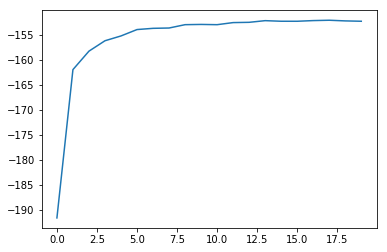

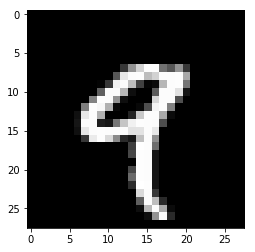

In [6]:
plt.plot(range(n_epoch),log_loss)
plt.show()
img = x_train[4,:].reshape(28,28)
plt.imshow(img, cmap='gray')
plt.show()

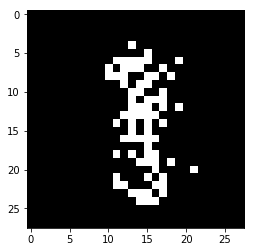

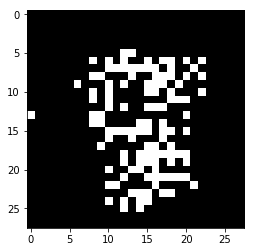

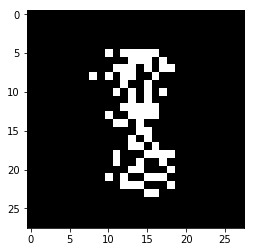

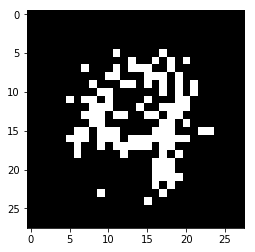

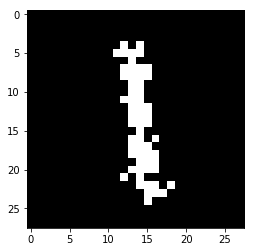

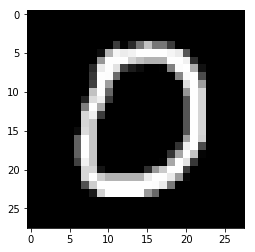

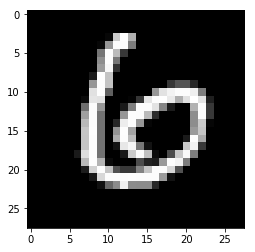

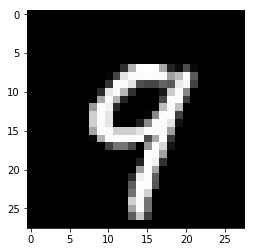

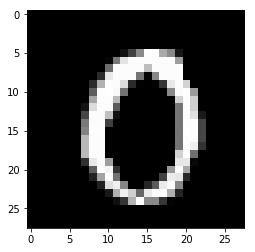

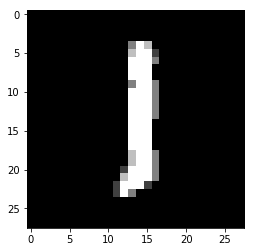

In [7]:
#sample_img = sess.run(x,feed_dict = {z:sampe_z})

sample_z = sess.run(qz, feed_dict = {x_ph: x_test[:100,:]})
img = sess.run(x, feed_dict = {z: sample_z})

for i in range(5):
    plt.imshow(img[i+10,:].reshape(28,28),cmap = 'gray')
    plt.show()
for i in range(5):
    plt.imshow(x_test[i+10,:].reshape(28,28),cmap = 'gray')
    plt.show()

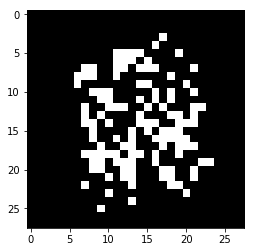

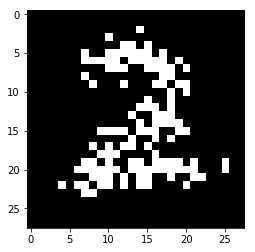

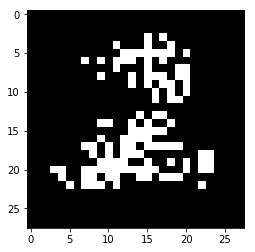

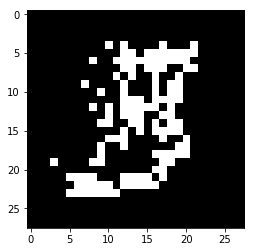

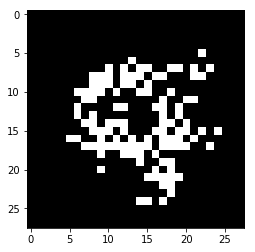

In [8]:
img = x.sample().eval()

for i in range(5):
    plt.imshow(img[i,:].reshape(28,28),cmap = 'gray')
    plt.show()
